In [16]:
from pathlib import Path
import sys

import numpy as np
import xarray as xr

sys.path.append("../")
from src.models.gr4j.pet import pet_oudin
from src.models.hbv.hbv import simulation
from src.readers.geom_reader import load_geodata
from src.utils.logger import setup_logger

logger = setup_logger(
    "hbv_debug_single_gauge", log_file="logs/hbv_debug_single_gauge.log"
)


In [6]:
# Load gauge data
logger.info("Loading gauge geometries")
_, gauges = load_geodata(folder_depth="../")
logger.info(f"Loaded {len(gauges)} gauges")

# Get available gauges
full_gauges = [
    i.stem for i in Path("../data/nc_all_q").glob("*.nc") if i.stem in gauges.index
]
logger.info(f"Found {len(full_gauges)} gauges with data")


# Select first gauge for debugging
gauge_id = full_gauges[0]
logger.info(f"Selected gauge for debugging: {gauge_id}")

point_geom = gauges.loc[gauge_id, "geometry"]
latitude = float(point_geom.y)  # type: ignore[union-attr]

# Configuration
calibration_period = ("2010-01-01", "2018-12-31")
validation_period = ("2019-01-01", "2020-12-31")
save_storage = Path("data/optimization/hbv_debug/")
save_storage.mkdir(parents=True, exist_ok=True)

# Use fewer trials for debugging, increase once model works
n_trials = 200  # Increased from 100 to get better parameters
timeout = 600  # 10 minutes
warmup_years = 2

# Test with first dataset only
dataset = "e5l"

logger.info("Configuration:")
logger.info(f"  Gauge: {gauge_id}")
logger.info(f"  Dataset: {dataset}")
logger.info(f"  Latitude: {latitude:.4f}")
logger.info(f"  Calibration: {calibration_period[0]} to {calibration_period[1]}")
logger.info(f"  Validation: {validation_period[0]} to {validation_period[1]}")
logger.info(f"  Trials: {n_trials}")
logger.info(f"  Timeout: {timeout}s")
logger.info(f"  Warmup: {warmup_years} years")

2025-10-20 01:07:35 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️  Loading gauge geometries


2025-10-20 01:07:36 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️  Loaded 996 gauges
2025-10-20 01:07:36 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️  Found 996 gauges with data
2025-10-20 01:07:36 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️  Selected gauge for debugging: 75257
2025-10-20 01:07:36 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️  Configuration:
2025-10-20 01:07:36 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️    Gauge: 75257
2025-10-20 01:07:36 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️    Dataset: e5l
2025-10-20 01:07:36 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️    Latitude: 58.2487
2025-10-20 01:07:36 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️    Calibration: 2010-01-01 to 2018-12-31
2025-10-20 01:07:36 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️    Validation: 2019-01-01 to 2020-12-31
2025-10-20 01:07:36 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️    Trials: 200
2025-10-20 01:07:36 |

In [18]:
logger.info("[Step 1/8] Loading NetCDF dataset")
nc_path = Path(f"../data/nc_all_q/{gauge_id}.nc")

logger.debug(f"Opening dataset: {nc_path}")
with xr.open_dataset(nc_path) as ds:
    logger.debug(f"Dataset variables: {list(ds.data_vars)}")
    logger.debug(f"Dataset coordinates: {list(ds.coords)}")
    df = ds.to_dataframe()

logger.info(f"Loaded dataframe shape: {df.shape}")
logger.debug(f"Dataframe columns: {df.columns.tolist()}")
logger.debug(f"Date range: {df.index[0]} to {df.index[-1]}")

# Step 2: Calculate mean temperature
logger.info("[Step 2/8] Calculating mean temperature")
df["t_mean_e5l"] = (df["t_max_e5l"] + df["t_min_e5l"]) / 2
logger.debug(
    f"Temperature range: "
    f"min={df['t_mean_e5l'].min():.2f}, "
    f"max={df['t_mean_e5l'].max():.2f}"
)

# Step 3: Slice data
logger.info("[Step 4/8] Slicing data for calibration")
prcp_col = f"prcp_{dataset}"
data_start_year = 2008
required_cols = ["q_mm_day", "t_mean_e5l", prcp_col]
hbv_data = df.loc[f"{data_start_year}" : "2020", required_cols].copy()
logger.info(f"HBV data shape: {hbv_data.shape}")
if "day_of_year" not in hbv_data.columns:
    hbv_data["day_of_year"] = hbv_data.index.dayofyear  # type: ignore[attr-defined]
evap = pet_oudin(
    hbv_data["t_mean_e5l"].tolist(),
    hbv_data["day_of_year"].tolist(),
    latitude,
)
hbv_data["Evap"] = np.asarray(evap, dtype=float)
hbv_data.rename(
    columns={
        "t_mean_e5l": "Temp",
        prcp_col: "Prec",
    },
    inplace=True,
)

2025-10-20 01:15:23 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️  [Step 1/8] Loading NetCDF dataset
2025-10-20 01:15:23 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️  Loaded dataframe shape: (4749, 24)
2025-10-20 01:15:23 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️  [Step 2/8] Calculating mean temperature
2025-10-20 01:15:23 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️  [Step 4/8] Slicing data for calibration
2025-10-20 01:15:23 | INFO     | PhDLogger | hbv_debug_single_gauge | ℹ️  HBV data shape: (4749, 3)


In [19]:
hbv_data


,q_mm_day,Temp,Prec,day_of_year,Evap
date,,,,,
2008-01-01,0.286095,-4.438327,1.229564,1,0.007304
2008-01-02,0.281727,-12.013475,0.118667,2,0.000000
2008-01-03,0.276268,-20.160638,0.011734,3,0.000000
2008-01-04,0.271900,-20.464331,0.011018,4,0.000000
2008-01-05,0.271900,-21.319149,0.039781,5,0.000000
...,...,...,...,...,...
2020-12-27,0.246784,-8.394263,0.886009,362,0.000000
2020-12-28,0.251152,-14.212449,0.096165,363,0.000000
2020-12-29,0.251152,-13.243887,0.114991,364,0.000000


In [20]:
best_parameters = {
    "parBETA": 5.536323294060305,
    "parFC": 213.05134376542867,
    "parLP": 0.8043260031149827,
    "parPERC": 2.098017907854798,
    "parUZL": 218.4963054381007,
    "parK0": 0.3819905530505137,
    "parK1": 0.11601996582222332,
    "parK2": 0.02962089172997493,
    "parMAXBAS": 4.683892399029672,
    "parCET": 0.08679762929201024,
    "parPCORR": 1.3296432938509186,
    "parTT": 0.2445191383259486,
    "parCFMAX": 3.5729086743398044,
    "parCFR": 0.015073294213194904,
    "parCWH": 0.045840726621620004,
    "parSFCF": 0.9588664507709393,
}

In [29]:
q_sim = simulation(data=hbv_data.loc[:"2017", :], params=best_parameters.values())

q_obs = hbv_data.loc[:"2017", "q_mm_day"]

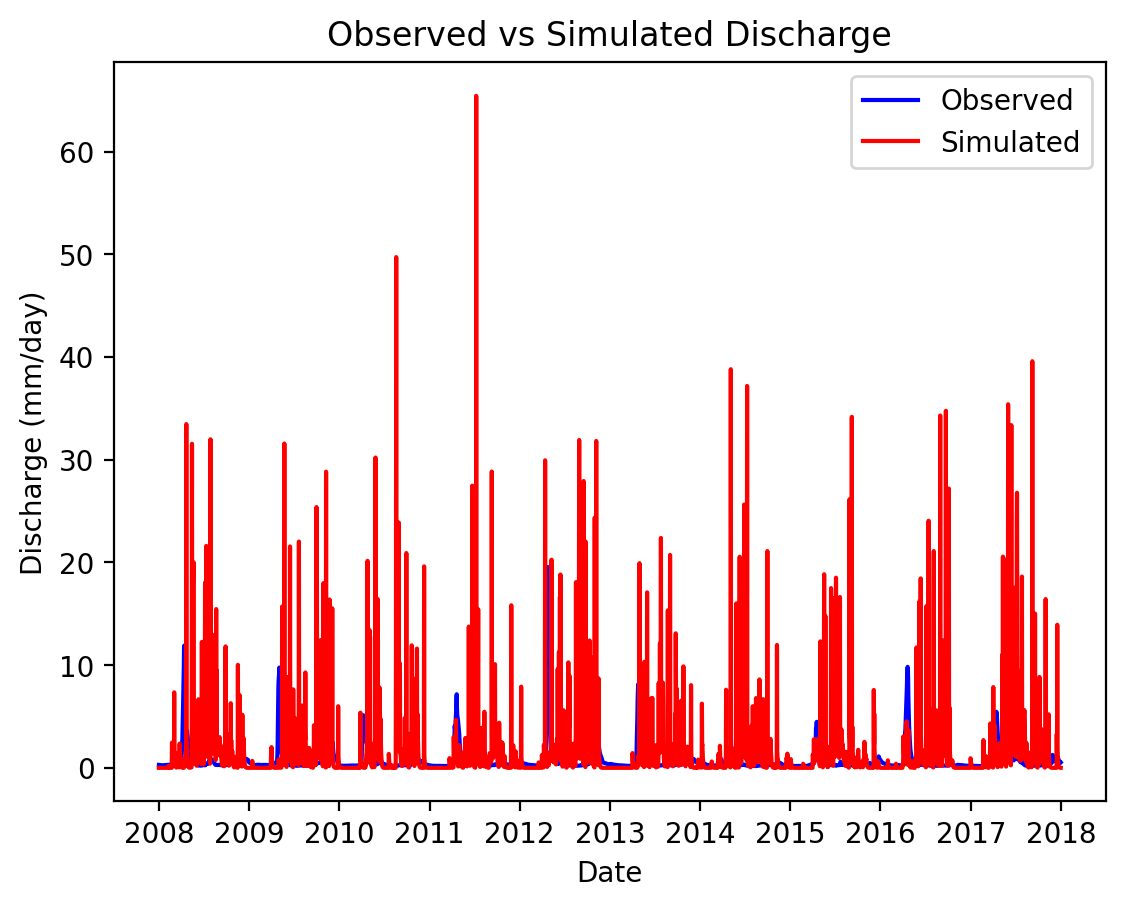

In [30]:
import matplotlib.pyplot as plt

plt.plot(q_obs.index, q_obs, label="Observed", color="blue")
plt.plot(q_obs.index, q_sim, label="Simulated", color="red")
plt.xlabel("Date")
plt.ylabel("Discharge (mm/day)")
plt.title("Observed vs Simulated Discharge")
plt.legend()
plt.show()

# Model Metrics Overview: GR4J, HBV, RFR with Different Meteo Sources

Overview of performance metrics for different hydrological models trained with different meteorological data sources.

In [29]:
import json
from pathlib import Path

import numpy as np
import pandas as pd

# Base paths for optimization results
BASE_PATHS = {
    "GR4J": Path(
        "/home/dmbrmv/Development/Dissertation/data/optimization/gr4j_simple_old"
    ),
    # "HBV": Path("/home/dmbrmv/Development/Dissertation/data/optimization/hbv_simple"),
    "RFR": Path("/home/dmbrmv/Development/Dissertation/data/optimization/rfr_simple"),
}

## Load Model Results and Metrics

Extract performance metrics from all model directories across different meteorological sources.

In [30]:
def load_metrics_from_directory(base_path: Path) -> dict:
    """Load all metrics from model optimization directory.

    Args:
        base_path: Path to model optimization directory.

    Returns:
        Dictionary with structure {gauge_id: {meteo_source: metrics_dict}}.
    """
    results = {}

    for gauge_dir in base_path.iterdir():
        if not gauge_dir.is_dir():
            continue

        gauge_id = gauge_dir.name
        results[gauge_id] = {}

        # Find all metrics files
        for metrics_file in gauge_dir.glob("*_metrics.json"):
            # Extract meteo source from filename (e.g., "10042_e5_metrics.json")
            parts = metrics_file.stem.split("_")
            meteo_source = "_".join(parts[1:-1])  # Get middle part(s)

            try:
                with open(metrics_file) as f:
                    metrics = json.load(f)
                    results[gauge_id][meteo_source] = metrics
            except (json.JSONDecodeError, FileNotFoundError):
                continue

    return results


# Load data for all models
model_data = {}
for model_name, base_path in BASE_PATHS.items():
    print(f"Loading {model_name} results from {base_path}...")
    model_data[model_name] = load_metrics_from_directory(base_path)
    print(f"  Found {len(model_data[model_name])} gauges")

print("\nSample meteo sources found:")
for model_name, data in model_data.items():
    if data:
        first_gauge = next(iter(data.values()))
        print(f"  {model_name}: {list(first_gauge.keys())}")

Loading GR4J results from /home/dmbrmv/Development/Dissertation/data/optimization/gr4j_simple_old...
  Found 996 gauges
Loading RFR results from /home/dmbrmv/Development/Dissertation/data/optimization/rfr_simple...
  Found 996 gauges

Sample meteo sources found:
  GR4J: ['mswep', 'gpcp', 'e5l', 'e5']
  RFR: ['mswep', 'gpcp', 'e5l', 'e5']


## Parse Meteorological Sources

Identify and extract meteorological source information from the model results.

In [31]:
# Identify all unique meteo sources across all models
all_meteo_sources = set()
for model_data_dict in model_data.values():
    for gauge_metrics in model_data_dict.values():
        all_meteo_sources.update(gauge_metrics.keys())

all_meteo_sources = sorted(list(all_meteo_sources))
print(f"All meteorological sources found: {all_meteo_sources}")
print(f"Total sources: {len(all_meteo_sources)}")

All meteorological sources found: ['e5', 'e5l', 'gpcp', 'mswep']
Total sources: 4


## Aggregate Metrics by Model and Source

Group metrics by model type and meteorological source. Calculate mean and median values.

In [32]:
def aggregate_metrics(model_data_dict: dict) -> dict:
    """Aggregate metrics by meteo source.

    Args:
        model_data_dict: Dictionary {gauge_id: {meteo_source: metrics}}.

    Returns:
        Dictionary {meteo_source: {metric_name: list_of_values}}.
    """
    aggregated = {}

    for gauge_id, sources_dict in model_data_dict.items():
        for meteo_source, metrics in sources_dict.items():
            if meteo_source not in aggregated:
                aggregated[meteo_source] = {}

            for metric_name, metric_value in metrics.items():
                if metric_name not in aggregated[meteo_source]:
                    aggregated[meteo_source][metric_name] = []

                # Only add numeric values
                if isinstance(metric_value, (int, float)):
                    aggregated[meteo_source][metric_name].append(metric_value)

    return aggregated


# Aggregate metrics for each model
aggregated_data = {}
for model_name, model_dict in model_data.items():
    aggregated_data[model_name] = aggregate_metrics(model_dict)

print("Aggregation complete.")
print("\nMetrics available for each source:")
for model_name in aggregated_data:
    sample_source = next(iter(aggregated_data[model_name].keys()), None)
    if sample_source:
        metrics = aggregated_data[model_name][sample_source]
        print(f"  {model_name}: {list(metrics.keys())}")

Aggregation complete.

Metrics available for each source:
  GR4J: ['NSE', 'KGE', 'PBIAS', 'RMSE', 'MAE', 'logNSE', 'R2', 'PFE']
  RFR: ['NSE', 'KGE', 'PBIAS', 'RMSE', 'MAE', 'logNSE', 'R2', 'r', 'PFE']


## Create Summary Statistics Table

Build a summary table with mean and median values for all metrics.

In [33]:
def build_summary_table(aggregated_data: dict) -> pd.DataFrame:
    """Build summary statistics table.

    Args:
        aggregated_data: Dictionary {model: {source: {metric: [values]}}}.

    Returns:
        DataFrame with rows as Model-Source combinations and columns as metrics.
    """
    rows = []

    for model_name, sources_dict in aggregated_data.items():
        for meteo_source, metrics_dict in sources_dict.items():
            row = {"Model": model_name, "Source": meteo_source}

            for metric_name, values in metrics_dict.items():
                if values:
                    values_array = np.array(values)
                    row[f"{metric_name}_median"] = np.nanmedian(values_array)
                    row[f"{metric_name}_mean"] = np.nanmean(values_array)

            rows.append(row)

    return pd.DataFrame(rows)


# Build the summary table
summary_df = build_summary_table(aggregated_data)
print(f"Summary table shape: {summary_df.shape}")
print(f"Columns: {list(summary_df.columns)}")

Summary table shape: (8, 20)
Columns: ['Model', 'Source', 'NSE_median', 'NSE_mean', 'KGE_median', 'KGE_mean', 'PBIAS_median', 'PBIAS_mean', 'RMSE_median', 'RMSE_mean', 'MAE_median', 'MAE_mean', 'logNSE_median', 'logNSE_mean', 'R2_median', 'R2_mean', 'PFE_median', 'PFE_mean', 'r_median', 'r_mean']


## Display Comparison Results

Show the summary statistics table with performance metrics for all model and meteo source combinations.

In [34]:
# Display full summary table
print("=" * 120)
print("SUMMARY STATISTICS: Model Performance by Meteorological Source")
print("=" * 120)

if len(summary_df) > 0:
    print(summary_df.to_string(index=False))
    print("=" * 120)

    # Create a pivot view for better comparison
    print("\n\nKEY FINDINGS:")
    print("-" * 120)

    # Get unique metrics
    all_columns = summary_df.columns.tolist()
    metric_names = set()
    for col in all_columns:
        if "_median" in col:
            metric_names.add(col.replace("_median", ""))

    print(f"Total model-source combinations: {len(summary_df)}")
    print(f"Unique metrics tracked: {len(metric_names)}")
    print(f"Metrics: {sorted(metric_names)}")
    print(f"\nModels: {summary_df['Model'].unique().tolist()}")
    print(f"Data sources: {summary_df['Source'].unique().tolist()}")
else:
    print("\n⚠️  No data loaded. Please ensure metrics files exist in:")
    for model_name, base_path in BASE_PATHS.items():
        print(f"   - {model_name}: {base_path}")
    print(
        "\nExpected file structure: {model_dir}/{gauge_id}/{gauge_id}_{source}_metrics.json"
    )
print("=" * 120)

SUMMARY STATISTICS: Model Performance by Meteorological Source
Model Source  NSE_median   NSE_mean  KGE_median  KGE_mean  PBIAS_median  PBIAS_mean  RMSE_median  RMSE_mean  MAE_median  MAE_mean  logNSE_median  logNSE_mean  R2_median  R2_mean  PFE_median   PFE_mean  r_median   r_mean
 GR4J  mswep    0.428188 -10.173235    0.573868  0.094417      2.036774   10.363079     0.561857   0.797474    0.296447  0.429461       0.402892    -0.374545   0.588332 0.557117  -14.819835   4.731009       NaN      NaN
 GR4J   gpcp    0.141058 -12.945112    0.185279 -0.151854      3.687356   22.762893     0.641397   0.976088    0.408430  0.583757       0.031228    -0.709161   0.366669 0.381296  -44.494174 -23.577654       NaN      NaN
 GR4J    e5l    0.514289 -18.329924    0.628494  0.062541      1.110303    8.770156     0.530271   0.737087    0.268765  0.379754       0.525367    -0.374728   0.667257 0.612779   -9.893943   8.529732       NaN      NaN
 GR4J     e5    0.447915  -6.360636    0.600264  0.124224